In [2]:
import glob
import os
import json
import pickle
import yaml

import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import utils
plt.rcParams.update({"font.size": 20})

In [3]:
! ls ../Feb22_2017

DYJetsToLL_Pt-100To250                  TTToHadronic
DYJetsToLL_Pt-250To400                  TTToSemiLeptonic
DYJetsToLL_Pt-400To650                  VBFHToTauTau
DYJetsToLL_Pt-50To100                   VBFHToWWToLNuQQ_M-125_withDipoleRecoil
DYJetsToLL_Pt-650ToInf                  WJetsToLNu_HT-100To200
GluGluHToTauTau                         WJetsToLNu_HT-1200To2500
GluGluHToWWToLNuQQ                      WJetsToLNu_HT-200To400
GluGluHToWW_Pt-200ToInf_M-125           WJetsToLNu_HT-2500ToInf
HWminusJ_HToWW_M-125                    WJetsToLNu_HT-400To600
HWplusJ_HToWW_M-125                     WJetsToLNu_HT-600To800
HZJ_HToWW_M-125                         WJetsToLNu_HT-70To100

QCD_Pt_1400to1800                       WJetsToQQ_HT-200to400
QCD_Pt_170to300                         WJetsToQQ_HT-400to600
QCD_Pt_1800to2400                       WJetsToQQ_HT-600to800
QCD_Pt_2400to3200                       WJetsToQQ_HT-800toInf
QCD_Pt_300to470                         WW
QCD_Pt_3200toInf       

In [4]:
combine_samples = {
    # data
    "SingleElectron_": "SingleElectron",    
    "SingleMuon_": "SingleMuon",  
    "EGamma_": "EGamma",    
    
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",    
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    "ttHToNonbb_M125": "ttHToNonbb_M125",
    
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",    
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
}

In [5]:
samples_dir = "../Feb22_2017"
samples = os.listdir(samples_dir)

channels = ["mu", "ele"]

weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
        "weight_vjets_nominal": 1,
    },
    "ele":{
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_electron": 1,
        "weight_reco_electron": 1,
        "weight_id_electron": 1,
        "weight_vjets_nominal": 1,   
    }
}

signals = [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBF"]

data_by_ch = {
    "ele": "SingleElectron",
    "mu": "SingleMuon",
}

nice_channel = {
    "mu": "Muon",
    "ele": "Electron"
}

In [6]:
def disc_score(df, sigs, bkgs):
    num = df[sigs].sum(axis=1) 
    den = df[sigs].sum(axis=1) + df[bkgs].sum(axis=1)
    return num/den

In [7]:
# scores definition
hwwev = ["fj_PN_probHWqqWev0c","fj_PN_probHWqqWev1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtauev1c"]
hwwmv = ["fj_PN_probHWqqWmv0c","fj_PN_probHWqqWmv1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtaumv1c"]
qcd = ["fj_PN_probQCDbb","fj_PN_probQCDcc","fj_PN_probQCDb","fj_PN_probQCDc","fj_PN_probQCDothers"]

tope = ["fj_PN_probTopbWev","fj_PN_probTopbWtauev"]
topm = ["fj_PN_probTopbWmv","fj_PN_probTopbWtaumv"]
tophad = ["fj_PN_probTopbWqq0c","fj_PN_probTopbWqq1c","fj_PN_probTopbWq0c","fj_PN_probTopbWq1c","fj_PN_probTopbWtauhv"]

top = tope+topm+tophad

# s/b

In [8]:
selections = {
    "mu": {
        ### pre-selection must include lepton isolation
        "pre-selection": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
        
        "mini-iso": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",
        "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )", 
        
        "QCD>0.99": "( QCD>0.99 )",
        "Top>0.9": "( Top>0.9 )",
        "inclusive>0.9": "( inclusive>0.9 )",
    },
    "ele": {
        "pre-selection": "( (fj_pt > 0) )",        
    },
}

In [9]:
cuts = {
    "pre-selection": ["pre-selection"],
    "pre-selection + mini-iso": ["pre-selection", "mini-iso"],
    "pre-selection + mini-iso + QCD>0.99": ["pre-selection", "mini-iso", "QCD>0.99"],
    "pre-selection + QCD>0.99": ["pre-selection", "QCD>0.99"],
    "pre-selection + mini-iso + Top>0.9": ["pre-selection", "mini-iso", "Top>0.9"],
    "pre-selection + mini-iso + bjet_ophem + Top>0.9": ["pre-selection", "mini-iso", "bjet_ophem", "Top>0.9"],
    "pre-selection + mini-iso + bjet_ophem + inclusive>0.9": ["pre-selection", "mini-iso", "bjet_ophem", "inclusive>0.9"],
}

In [10]:
sigs = {
    "ele": hwwev,
    "mu": hwwmv,
}


qcd_bkg = [b.replace("PN","ParT") for b in qcd]
top_bkg = [b.replace("PN","ParT") for b in tope+topm+tophad]
inclusive_bkg = [b.replace("PN","ParT") for b in qcd+tope+topm+tophad]

channels = ["mu"]#, "ele"]
is_data = False

events_dict = {}
for ch in channels:
    events_dict[ch] = {}

    for cut in cuts:
        events_dict[ch][cut] = {}

    new_sig = [s.replace("PN","ParT") for s in sigs[ch]]

    # get lumi
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch]["2017"]

    for sample in samples:

        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample

        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                

        data = pd.read_parquet(parquet_files)
        empty = len(data) == 0
        if empty:
            continue

        # get event_weight
    #     print(f"---> Retrieving event weight.")                
        event_weight = utils.get_xsecweight(pkl_files, "2017", sample, is_data, luminosity)
        for w in weights[ch]:
            if w not in data.keys():
    #             print(f"{w} weight is not stored in parquet")
                continue
            event_weight *= data[w]

        data["event_weight"] = event_weight
        
        # add QCD score 
        data["QCD"] = disc_score(data,new_sig,qcd_bkg)
        # add TOP score 
        data["Top"] = disc_score(data,new_sig,top_bkg)    
        # add inclusive score
        data["inclusive"] = disc_score(data,new_sig,inclusive_bkg)
            
        print(f"---> We have {len(data)} events.")        
        # apply selection
        
        for cut in cuts:
            print(f"Check {cut}")
            for selection in cuts[cut]:
                data1 = data.query(selections[ch][selection])           
                print(f"---> Applied {selection}... Only {len(data1)} events survived.")        
            
            ### specefy columns to keep
            columns_ = ["fj_ParT_mass", "lep_fj_m", "event_weight"]

            # fill the big dataframe
            if sample_to_use not in events_dict[ch][cut]:
                events_dict[ch][cut][sample_to_use] = data1[columns_]
            else:
                events_dict[ch][cut][sample_to_use] = pd.concat([events_dict[ch][cut][sample_to_use], data1[columns_]])

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> We have 964 events.
Check pre-selection
---> Applied pre-selection... Only 949 events survived.
Check pre-selection + mini-iso
---> Applied pre-selection... Only 949 events survived.
---> Applied mini-iso... Only 946 events survived.
Check pre-selection + mini-iso + QCD>0.99
---> Applied pre-selection... Only 949 events survived.
---> Applied mini-iso... Only 946 events survived.
---> Applied QCD>0.99... Only 870 events survived.
Check pre-selection + QCD>0.99
---> Applied pre-selection... Only 949 events survived.
---> Applied QCD>0.99... Only 870 events survived.
Check pre-selection + mini-iso + Top>0.9
---> Applied pre-selection... Only 949 events survived.
---> Applied mini-iso... Only 946 events survived.
---> Applied Top>0.9... Only 98 events survived.
Check pre-selection + mini-iso + bjet_ophem + Top>0.9
---> Applied pre-selection... Only 949 events survived.
---> Applied mini-iso... Only 946 even

---> Applied mini-iso... Only 848392 events survived.
---> Applied bjet_ophem... Only 329949 events survived.
---> Applied inclusive>0.9... Only 35556 events survived.
Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
---> We have 78081 events.
Check pre-selection
---> Applied pre-selection... Only 77680 events survived.
Check pre-selection + mini-iso
---> Applied pre-selection... Only 77680 events survived.
---> Applied mini-iso... Only 76944 events survived.
Check pre-selection + mini-iso + QCD>0.99
---> Applied pre-selection... Only 77680 events survived.
---> Applied mini-iso... Only 76944 events survived.
---> Applied QCD>0.99... Only 61707 events survived.
Check pre-selection + QCD>0.99
---> Applied pre-selection... Only 77680 events survived.
---> Applied QCD>0.99... Only 61707 events survived.
Check pre-selection + mini-iso + Top>0.9
---> Applied pre-selection... Only 77680 events survived.
---> Applied mini-iso... Only 76944 events survived.
---> Appl

---> We have 14 events.
Check pre-selection
---> Applied pre-selection... Only 8 events survived.
Check pre-selection + mini-iso
---> Applied pre-selection... Only 8 events survived.
---> Applied mini-iso... Only 6 events survived.
Check pre-selection + mini-iso + QCD>0.99
---> Applied pre-selection... Only 8 events survived.
---> Applied mini-iso... Only 6 events survived.
---> Applied QCD>0.99... Only 0 events survived.
Check pre-selection + QCD>0.99
---> Applied pre-selection... Only 8 events survived.
---> Applied QCD>0.99... Only 0 events survived.
Check pre-selection + mini-iso + Top>0.9
---> Applied pre-selection... Only 8 events survived.
---> Applied mini-iso... Only 6 events survived.
---> Applied Top>0.9... Only 0 events survived.
Check pre-selection + mini-iso + bjet_ophem + Top>0.9
---> Applied pre-selection... Only 8 events survived.
---> Applied mini-iso... Only 6 events survived.
---> Applied bjet_ophem... Only 13 events survived.
---> Applied Top>0.9... Only 0 events s

---> We have 36205 events.
Check pre-selection
---> Applied pre-selection... Only 35307 events survived.
Check pre-selection + mini-iso
---> Applied pre-selection... Only 35307 events survived.
---> Applied mini-iso... Only 34860 events survived.
Check pre-selection + mini-iso + QCD>0.99
---> Applied pre-selection... Only 35307 events survived.
---> Applied mini-iso... Only 34860 events survived.
---> Applied QCD>0.99... Only 20579 events survived.
Check pre-selection + QCD>0.99
---> Applied pre-selection... Only 35307 events survived.
---> Applied QCD>0.99... Only 20579 events survived.
Check pre-selection + mini-iso + Top>0.9
---> Applied pre-selection... Only 35307 events survived.
---> Applied mini-iso... Only 34860 events survived.
---> Applied Top>0.9... Only 693 events survived.
Check pre-selection + mini-iso + bjet_ophem + Top>0.9
---> Applied pre-selection... Only 35307 events survived.
---> Applied mini-iso... Only 34860 events survived.
---> Applied bjet_ophem... Only 9755 e

---> Applied inclusive>0.9... Only 12811 events survived.
Finding ttHToTauTau samples and should combine them under ttHToTauTau
No parquet file for ttHToTauTau
Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> We have 3443 events.
Check pre-selection
---> Applied pre-selection... Only 2881 events survived.
Check pre-selection + mini-iso
---> Applied pre-selection... Only 2881 events survived.
---> Applied mini-iso... Only 671 events survived.
Check pre-selection + mini-iso + QCD>0.99
---> Applied pre-selection... Only 2881 events survived.
---> Applied mini-iso... Only 671 events survived.
---> Applied QCD>0.99... Only 45 events survived.
Check pre-selection + QCD>0.99
---> Applied pre-selection... Only 2881 events survived.
---> Applied QCD>0.99... Only 45 events survived.
Check pre-selection + mini-iso + Top>0.9
---> Applied pre-selection... Only 2881 events survived.
---> Applied mini-iso... Only 671 events survived.
---> Applied Top>0.9... Only 59 events surv

---> Applied pre-selection... Only 16884 events survived.
---> Applied mini-iso... Only 3443 events survived.
---> Applied bjet_ophem... Only 16022 events survived.
---> Applied inclusive>0.9... Only 193 events survived.
Finding QCD_Pt_600to800 samples and should combine them under QCD
---> We have 14340 events.
Check pre-selection
---> Applied pre-selection... Only 12151 events survived.
Check pre-selection + mini-iso
---> Applied pre-selection... Only 12151 events survived.
---> Applied mini-iso... Only 2647 events survived.
Check pre-selection + mini-iso + QCD>0.99
---> Applied pre-selection... Only 12151 events survived.
---> Applied mini-iso... Only 2647 events survived.
---> Applied QCD>0.99... Only 176 events survived.
Check pre-selection + QCD>0.99
---> Applied pre-selection... Only 12151 events survived.
---> Applied QCD>0.99... Only 176 events survived.
Check pre-selection + mini-iso + Top>0.9
---> Applied pre-selection... Only 12151 events survived.
---> Applied mini-iso... 

---> We have 7609 events.
Check pre-selection
---> Applied pre-selection... Only 5847 events survived.
Check pre-selection + mini-iso
---> Applied pre-selection... Only 5847 events survived.
---> Applied mini-iso... Only 2091 events survived.
Check pre-selection + mini-iso + QCD>0.99
---> Applied pre-selection... Only 5847 events survived.
---> Applied mini-iso... Only 2091 events survived.
---> Applied QCD>0.99... Only 313 events survived.
Check pre-selection + QCD>0.99
---> Applied pre-selection... Only 5847 events survived.
---> Applied QCD>0.99... Only 313 events survived.
Check pre-selection + mini-iso + Top>0.9
---> Applied pre-selection... Only 5847 events survived.
---> Applied mini-iso... Only 2091 events survived.
---> Applied Top>0.9... Only 889 events survived.
Check pre-selection + mini-iso + bjet_ophem + Top>0.9
---> Applied pre-selection... Only 5847 events survived.
---> Applied mini-iso... Only 2091 events survived.
---> Applied bjet_ophem... Only 6977 events survived.

Check pre-selection + QCD>0.99
---> Applied pre-selection... Only 91690 events survived.
---> Applied QCD>0.99... Only 87569 events survived.
Check pre-selection + mini-iso + Top>0.9
---> Applied pre-selection... Only 91690 events survived.
---> Applied mini-iso... Only 91444 events survived.
---> Applied Top>0.9... Only 20537 events survived.
Check pre-selection + mini-iso + bjet_ophem + Top>0.9
---> Applied pre-selection... Only 91690 events survived.
---> Applied mini-iso... Only 91444 events survived.
---> Applied bjet_ophem... Only 86486 events survived.
---> Applied Top>0.9... Only 20537 events survived.
Check pre-selection + mini-iso + bjet_ophem + inclusive>0.9
---> Applied pre-selection... Only 91690 events survived.
---> Applied mini-iso... Only 91444 events survived.
---> Applied bjet_ophem... Only 86486 events survived.
---> Applied inclusive>0.9... Only 20440 events survived.
Finding QCD_Pt_470to600 samples and should combine them under QCD
---> We have 10424 events.
Check

In [11]:
for cut in cuts:
    print(cut)

pre-selection
pre-selection + mini-iso
pre-selection + mini-iso + QCD>0.99
pre-selection + QCD>0.99
pre-selection + mini-iso + Top>0.9
pre-selection + mini-iso + bjet_ophem + Top>0.9
pre-selection + mini-iso + bjet_ophem + inclusive>0.9


In [12]:
events_dict.keys()

dict_keys(['mu'])

In [13]:
events_dict["mu"].keys()

dict_keys(['pre-selection', 'pre-selection + mini-iso', 'pre-selection + mini-iso + QCD>0.99', 'pre-selection + QCD>0.99', 'pre-selection + mini-iso + Top>0.9', 'pre-selection + mini-iso + bjet_ophem + Top>0.9', 'pre-selection + mini-iso + bjet_ophem + inclusive>0.9'])

## Get cutflows and s/b

In [15]:
cutflows = {}
for sample in events_dict["mu"][cut]:
    cutflows[sample] = {}

s, b = {}, {}
for cut in events_dict["mu"]:
    s[cut], b[cut] = 0, 0
    
    for sample in events_dict["mu"][cut]:
        
        ### cutflows
        cutflows[sample][cut] = len(events_dict["mu"][cut][sample])
        
        ### s/b
        ev_weight = events_dict["mu"][cut][sample]["event_weight"]
        
        regressed_mass = events_dict[ch][cut][sample]["fj_ParT_mass"]        
        mass_window = (regressed_mass>100) & (regressed_mass<150)

        if sample in signals:
            s[cut] += ev_weight[mass_window].sum()
        else:
            b[cut] += ev_weight[mass_window].sum()            

In [16]:
for cut in s:
    print(f"{cut} : s/b = {s[cut]/math.sqrt(b[cut])}")

pre-selection : s/b = 0.3104906273733283
pre-selection + mini-iso : s/b = 0.3466072383650803
pre-selection + mini-iso + QCD>0.99 : s/b = 0.4110797635243366
pre-selection + QCD>0.99 : s/b = 0.4110797635243366
pre-selection + mini-iso + Top>0.9 : s/b = 0.4953642149989201
pre-selection + mini-iso + bjet_ophem + Top>0.9 : s/b = 0.4953642149989201
pre-selection + mini-iso + bjet_ophem + inclusive>0.9 : s/b = 0.5143324217310036


In [17]:
for sample in cutflows:
    print(sample)    
    for cut in cutflows[sample]:
        print(f"{cut} : {cutflows[sample][cut]}")
    print("---------------------------------")            

WJetsLNu
pre-selection : 878975
pre-selection + mini-iso : 865440
pre-selection + mini-iso + QCD>0.99 : 733369
pre-selection + QCD>0.99 : 733369
pre-selection + mini-iso + Top>0.9 : 177580
pre-selection + mini-iso + bjet_ophem + Top>0.9 : 177580
pre-selection + mini-iso + bjet_ophem + inclusive>0.9 : 176188
---------------------------------
DYJets
pre-selection : 229544
pre-selection + mini-iso : 226779
pre-selection + mini-iso + QCD>0.99 : 199145
pre-selection + QCD>0.99 : 199145
pre-selection + mini-iso + Top>0.9 : 29126
pre-selection + mini-iso + bjet_ophem + Top>0.9 : 29126
pre-selection + mini-iso + bjet_ophem + inclusive>0.9 : 28930
---------------------------------
VBF
pre-selection : 1150
pre-selection + mini-iso : 1097
pre-selection + mini-iso + QCD>0.99 : 1101
pre-selection + QCD>0.99 : 1101
pre-selection + mini-iso + Top>0.9 : 629
pre-selection + mini-iso + bjet_ophem + Top>0.9 : 629
pre-selection + mini-iso + bjet_ophem + inclusive>0.9 : 628
--------------------------------

# Old code

In [ ]:
pd.options.mode.chained_assignment = None

# presel = {
#     "mu": {
#         "pre-selection + others + miso<0.1": "( (fj_bjets_ophem<0.3040) & ( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) ) & ( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) ))",
#         "pre-selection + others + miso<0.15": "( (fj_bjets_ophem<0.3040) & ( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) ) & ( (lep_pt < 55) |  ( (lep_misolation < 0.15) & (lep_pt >= 55) ) ))",                
#         "pre-selection + others + miso<0.2": "( (fj_bjets_ophem<0.3040) & ( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) ) & ( (lep_pt < 55) |  ( (lep_misolation < 0.2) & (lep_pt >= 55) ) ))",
#         "pre-selection + others + miso<0.2.5": "( (fj_bjets_ophem<0.3040) & ( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) ) & ( (lep_pt < 55) |  ( (lep_misolation < 0.25) & (lep_pt >= 55) ) ))",
#         "pre-selection + others + miso<0.3": "( (fj_bjets_ophem<0.3040) & ( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) ) & ( (lep_pt < 55) |  ( (lep_misolation < 0.3) & (lep_pt >= 55) ) ))",
#     },
#     "ele": {
#         "pre-selection": "( (fj_pt > 0) )",
#     },        
# }

# presel = {
#     "mu": {
#         "pre-selection": "( (fj_pt > 0) )",
#         "pre-selection + bjet cut": "( (fj_bjets_ophem < 0.3040) )",                
#         "pre-selection + isolation cut": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
#         "pre-selection + mini-isolation cut": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",  
#         "pre-selection + all of the above": "( (fj_bjets_ophem<0.3040) & ( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) ) & ( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) ))",
#     },
#     "ele": {
#         "pre-selection": "( (fj_pt > 0) )",
#         "pre-selection + bjet cut": "( (fj_bjets_ophem < 0.3040) )",                
#         "pre-selection + isolation cut": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
#         "pre-selection + all of the above": "( (fj_bjets_ophem<0.3040) & ( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) ))",
#     },    
# }


presel = {
    "mu": {
        "preselection": "( (fj_pt > 0) )",
        "preselection + bjet_ophem": "( (fj_bjets_ophem < 0.3040) )",                
        "preselection + isolation": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
        "preselection + mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",  
        "preselection + all of the above": "( (fj_bjets_ophem<0.3040) & ( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) ) & ( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) ))",
    },
    "ele": {
        "preselection": "( (fj_pt > 0) )",
#         "preselection + bjet_ophem": "( (fj_bjets_ophem < 0.3040) )",

        "preselection + bjet_ophem": "( (fj_pt>0) )",
        "preselection + isolation": "( (fj_pt>0) )",
        "preselection + mini-isolation": "( (fj_pt>0) )",
        "preselection + all of the above": "( (fj_pt>0) )"
        
#         "preselection + isolation": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
#         "preselection + all of the above": "( (fj_bjets_ophem<0.3040) )"#" & ( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) ))",

    },    
}


# scores definition
hwwev = ["fj_PN_probHWqqWev0c","fj_PN_probHWqqWev1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtauev1c"]
hwwmv = ["fj_PN_probHWqqWmv0c","fj_PN_probHWqqWmv1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtaumv1c"]
tope = ["fj_PN_probTopbWev","fj_PN_probTopbWtauev"]
topm = ["fj_PN_probTopbWmv","fj_PN_probTopbWtaumv"]
tophad = ["fj_PN_probTopbWqq0c","fj_PN_probTopbWqq1c","fj_PN_probTopbWq0c","fj_PN_probTopbWq1c","fj_PN_probTopbWtauhv"]
qcd = ["fj_PN_probQCDbb","fj_PN_probQCDcc","fj_PN_probQCDb","fj_PN_probQCDc","fj_PN_probQCDothers"]


sigs = (hwwev + hwwmv)
bkgs = (tope + topm + tophad + qcd)

channels = ["mu", "ele"]

is_data = False

events_dict = {}
for selection in presel[ch]:
    events_dict[selection] = {}
for ch in channels:
    print(ch)

    new_sig = [s.replace("PN","ParT") for s in sigs]
    new_bkg = [b.replace("PN","ParT") for b in bkgs]

    # get lumi
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch]["2017"]

    for sample in samples:

        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample

        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                

        data = pd.read_parquet(parquet_files)
        empty = len(data) == 0
        if empty:
            continue

        # get event_weight
#         print(f"---> Retrieving event weight.")                
        event_weight = utils.get_xsecweight(pkl_files, "2017", sample, is_data, luminosity)
        for w in weights[ch]:
            if w not in data.keys():
#                 print(f"{w} weight is not stored in parquet")
                continue
            event_weight *= data[w]

        data["event_weight"] = event_weight

        print(f"---> We have {len(data)} events.")
        
        # apply selection
        for selection in presel[ch]:
            
            data1 = data.query(presel[ch][selection])  
            print(f"---> Applied {selection}... Only {len(data1)} events survived.")        

            # add score 
            data1["score"] = disc_score(data1,new_sig,new_bkg)

            ### specefy columns to keep
            columns_ = ["score", "fj_ParT_mass", "lep_fj_m", "event_weight"]

            # fill the big dataframe
            if sample_to_use not in events_dict[selection]:
                events_dict[selection][sample_to_use] = data1[columns_]
            else:
                events_dict[selection][sample_to_use] = pd.concat([events_dict[selection][sample_to_use], data1[columns_]])

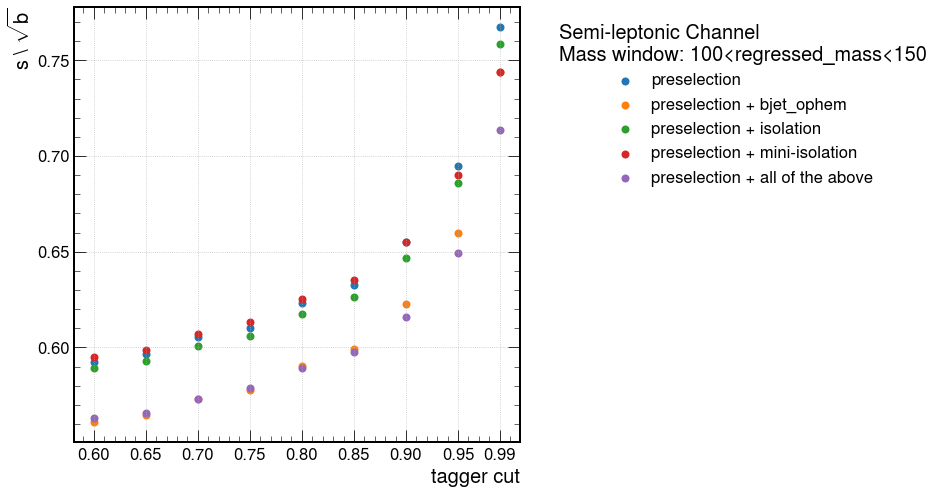

In [49]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8,8))
ax.grid()    

for selection in events_dict:

    cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

    s = [0]*len(cuts)
    b = [0]*len(cuts)

    for sample in events_dict[selection]:
        ev_weight = events_dict[selection][sample]["event_weight"]
        score = events_dict[selection][sample]["score"]

        regressed_mass = events_dict[selection][sample]["fj_ParT_mass"]
        mass_window = (regressed_mass>100) & (regressed_mass<150)

        for i, cut in enumerate(cuts):
            score_cut = (score > cut)
            if sample in signals:
                s[i] += ev_weight[mass_window & score_cut].sum()     
            else:
                b[i] += ev_weight[mass_window & score_cut].sum()

    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(cuts, ss/np.sqrt(bb) , linewidth=2.0, label=selection)

ax.set_xticks(cuts)
ax.set_xlabel("tagger cut")
ax.set_ylabel(r"s \ $\sqrt{b}$")
xch = nice_channel[ch]
ax.legend(title=f"Semi-leptonic Channel \nMass window: 100<regressed_mass<150", bbox_to_anchor=(1.05, 1), loc="upper left",);

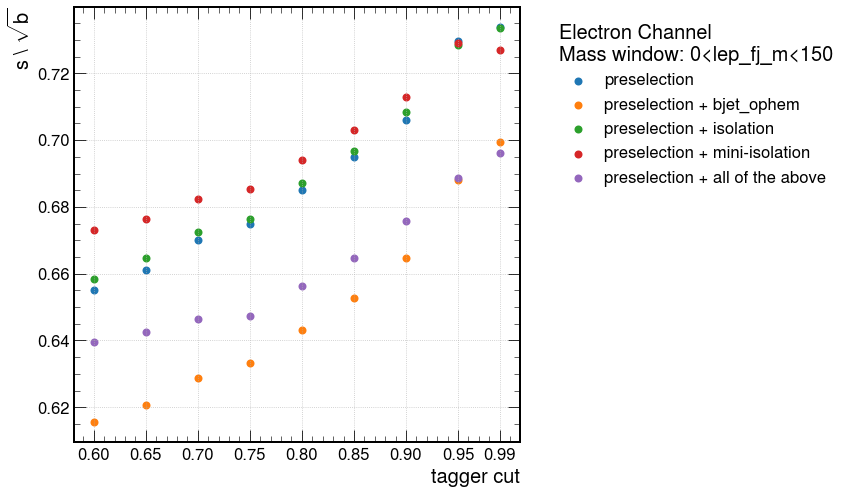

In [50]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8,8))
ax.grid()    

for selection in events_dict:

    cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

    s = [0]*len(cuts)
    b = [0]*len(cuts)

    for sample in events_dict[selection]:
        ev_weight = events_dict[selection][sample]["event_weight"]
        score = events_dict[selection][sample]["score"]

        lep_fj_m = events_dict[selection][sample]["lep_fj_m"]
        mass_window = (lep_fj_m>0) & (lep_fj_m<150)

        for i, cut in enumerate(cuts):
            score_cut = (score > cut)
            if sample in signals:
                s[i] += ev_weight[mass_window & score_cut].sum()     
            else:
                b[i] += ev_weight[mass_window & score_cut].sum()

    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(cuts, ss/np.sqrt(bb) , linewidth=2.0, label=selection)

ax.set_xticks(cuts)
ax.set_xlabel("tagger cut")
ax.set_ylabel(r"s \ $\sqrt{b}$")
xch = nice_channel[ch]

ax.legend(title=f"{xch} Channel \nMass window: 0<lep_fj_m<150", bbox_to_anchor=(1.05, 1), loc="upper left",);

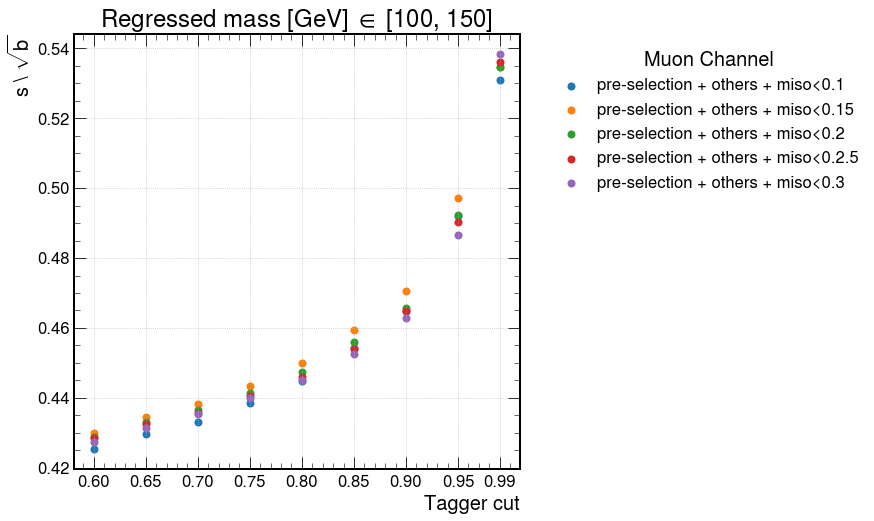

In [11]:
plt.rcParams.update({"font.size": 20})

for ch in channels:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.grid()
    
    for selection in events_dict[ch]:

        cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

        s = [0]*len(cuts)
        b = [0]*len(cuts)

        for sample in events_dict[ch][selection].keys():
            ev_weight = events_dict[ch][selection][sample]["event_weight"]
            score = events_dict[ch][selection][sample]["score"]

            regressed_mass = events_dict[ch][selection][sample]["fj_ParT_mass"]
            mass_window = (regressed_mass>100) & (regressed_mass<150)

            for i, cut in enumerate(cuts):
                score_cut = (score > cut)
                if sample in signals:
                    s[i] += ev_weight[mass_window & score_cut].sum()     
                else:
                    b[i] += ev_weight[mass_window & score_cut].sum()
        ss = np.array(s)
        bb = np.array(b)
        ax.scatter(cuts, ss/np.sqrt(bb) , linewidth=2.0, label=selection)

    ax.set_xticks(cuts)
    ax.set_xlabel("Tagger cut")
    ax.set_ylabel(r"s \ $\sqrt{b}$")
    xch = nice_channel[ch]
    ax.legend(title=f"{xch} Channel", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.set_title(r"Regressed mass [GeV] $\in$ [100, 150]")